In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb(pretty=True)

In [2]:
import time
import jax
import os
import pickle
import numpy as np
import jax.numpy as jnp
import scipy.spatial
import matplotlib.pyplot as plt
from confirm.mini_imprint import grid
from confirm.lewislib import grid as lewgrid
from confirm.lewislib import lewis, batch
from confirm.mini_imprint import binomial

from rich import print as rprint

In [3]:
# Configuration used during simulation
name = '3d'
params = {
    "n_arms": 3,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}

lei_obj = lewis.Lewis45(**params)
n_arm_samples = int(lei_obj.unifs_shape()[0])

In [4]:
def lewis_tune(alpha, theta, null_truth, unifs, unifs_order):
    p = jax.scipy.special.expit(theta)
    sim_size = unifs.shape[0]
    simulatev = jax.vmap(lei_obj.simulate, in_axes=(None, 0, None))
    test_stats, best_arms, _ = simulatev(p, unifs, unifs_order)
    # anywhere that we have a correct rejection, stick in 2 for the test stat so
    # that we can be sure to never include those simulations as false rejections.
    false_test_stats = jnp.where(null_truth[best_arms - 1], test_stats, 2.0)
    # k_null = jnp.sum(null_truth[best_arms - 1])
    sorted_stats = jnp.sort(false_test_stats, axis=-1)
    # cv_idx in the paper is 1-indexed, so we need to subtract 1 to be
    # 0-indexed
    cv_idx = jnp.floor((sim_size + 1) * alpha).astype(int) - 1
    sim_cv = sorted_stats[cv_idx]
    return (sim_cv,)


def lewis_sim(cv, theta, null_truth, unifs, unifs_order):
    p = jax.scipy.special.expit(theta)
    sim_size = unifs.shape[0]
    simulatev = jax.vmap(lei_obj.simulate, in_axes=(None, 0, None))
    test_stats, best_arms, _ = simulatev(p, unifs, unifs_order)
    rej = test_stats < cv
    false_rej = rej * null_truth[best_arms - 1]
    return (np.sum(false_rej),)


tunev = jax.jit(jax.vmap(lewis_tune, in_axes=(0, 0, 0, None, None)))
simv = jax.jit(jax.vmap(lewis_sim, in_axes=(0, 0, 0, None, None)))


In [5]:
def grouped_by_sim_size(f, max_grid_batch_size):
    def internal(sim_sizes, T, theta, null_truth, unifs, unifs_order):
        unique_sizes = np.unique(sim_sizes)
        out = np.empty(theta.shape[0])
        for size in unique_sizes:
            idx = (sim_sizes == size)
            start = time.time()
            grid_batch_size = min(int(1e9 / n_arm_samples / size), max_grid_batch_size)
            f_batched = batch.batch_all_concat(f, grid_batch_size, in_axes=(0, 0, 0, None, None))
            out[idx] = f_batched(
                T[idx], theta[idx], null_truth[idx], unifs[:size], unifs_order[:size]
            )[0]
            end = time.time()
            print('running for size', size, 'with', np.sum(idx), 'tiles took', end - start)
        return out

    return internal


In [7]:
n_arms = params['n_arms']
ns = np.concatenate(
    [np.ones(n_arms - 1)[:, None], -np.eye(n_arms - 1)],
    axis=-1,
)
null_hypos = [grid.HyperPlane(n, 0) for n in ns]
symmetry = []
for i in range(n_arms - 2):
    n = np.zeros(n_arms)
    n[i + 1] = 1
    n[i + 2] = -1
    symmetry.append(grid.HyperPlane(n, 0))

theta_min = -1.0
theta_max = 1.0
init_grid_size = 4
theta, radii = grid.cartesian_gridpts(
    np.full(n_arms, theta_min),
    np.full(n_arms, theta_max),
    np.full(n_arms, init_grid_size),
)

for syms in [symmetry, []]:
    g = grid.build_grid(theta, radii, null_hypos=null_hypos, symmetry_planes=syms, should_prune=True)
    print(g.n_tiles)

44
70


'cpu'

In [15]:
target_grid_cost = 0.001
target_sim_cost = 0.001
target_alpha = 0.025
holderq = 6
delta_validate = 0.01

max_grid_batch_size = 2**6 if jax.devices()[0].device_kind == 'cpu' else 2**10
max_sim_size = 2**17
init_nsims = 2000
seed = 0
key = jax.random.PRNGKey(seed)

unifs = jax.random.uniform(key=key, shape=(max_sim_size,) + lei_obj.unifs_shape())
unifs_order = np.arange(0, unifs.shape[1])

batched_tune = grouped_by_sim_size(tunev, max_grid_batch_size)
batched_sim = grouped_by_sim_size(simv, max_grid_batch_size)
batched_invert_bound = batch.batch_all_concat(
    lambda *args: (binomial.invert_bound(*args),),
    max_grid_batch_size,
    in_axes=(None, 0, 0, None, None)
)


In [18]:
load_iter = 43
if load_iter == 0:
    sim_sizes = np.full(g.n_tiles, init_nsims)
    sim_cvs = np.empty(g.n_tiles, dtype=float)
    typeI_sum = np.empty(g.n_tiles, dtype=float)
    hob_upper = np.empty(g.n_tiles, dtype=float)
    pointwise_target_alpha = np.empty(g.n_tiles, dtype=float)
    todo = np.ones(g.n_tiles, dtype=bool)
else:
    with open(f'{name}/{load_iter}.pkl', 'rb') as f:
        g, sim_sizes, sim_cvs, typeI_sum, hob_upper, pointwise_target_alpha = pickle.load(f)
    todo = np.zeros(g.n_tiles, dtype=bool)
    todo[-1] = True


adafrac = 0.8
iter_max = 70
for II in range(load_iter + 1, iter_max):
    if np.sum(todo) == 0:
        break

    print(f'starting iteration {II} with {np.sum(todo)} tiles to process')
    start = time.time()

    pointwise_target_alpha[todo] = batched_invert_bound(
        target_alpha, g.theta_tiles[todo], g.vertices[todo], n_arm_samples, holderq
    )[0]
    print('inverting the bound took', time.time() - start)
    start = time.time()

    sim_cvs[todo] = batched_tune(
        sim_sizes[todo],
        pointwise_target_alpha[todo],
        g.theta_tiles[todo],
        g.null_truth[todo],
        unifs,
        unifs_order,
    )
    overall_cv = np.min(sim_cvs)
    print('tuning took', time.time() - start)

    # typeI_sum[todo] = batched_sim(
    #     sim_sizes[todo],
    #     np.full(todo.sum(), overall_cv),
    #     g.theta_tiles[todo],
    #     g.null_truth[todo],
    #     unifs,
    #     unifs_order,
    # )
    # import pickle

    # typeI_est, typeI_CI = binomial.zero_order_bound(
    #     typeI_sum, sim_sizes, delta_validate, 1.0
    # )
    # typeI_bound = typeI_est + typeI_CI
    # hob_upper = binomial.holder_odi_bound(
    #     typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
    # )
    # sim_cost = typeI_CI
    # hob_empirical_cost = hob_upper - typeI_bound

    todo[:] = False
        
    hob_theory_cost = target_alpha - pointwise_target_alpha

    worst_tile = np.argmin(sim_cvs)
    which_refine = (sim_cvs <= (1.0 / adafrac) * overall_cv) & (hob_theory_cost > target_grid_cost)
    which_refine |= hob_theory_cost > target_alpha
    # which_refine = (
    #     hob_theory_cost > max(adafrac * hob_theory_cost[worst_tile], target_grid_cost)
    # ) & (
    #     (hob_upper > adafrac * hob_upper[worst_tile]) | (sim_cvs == sim_cvs[worst_tile])
    # )
    # which_more_sims = (
    #     typeI_CI > max(adafrac * typeI_CI[worst_tile], target_sim_cost)
    # ) & (
    #     (typeI_bound > adafrac * hob_upper[worst_tile])
    #     | (sim_cvs == sim_cvs[worst_tile])
    # )
    savedata = [g, sim_sizes, sim_cvs, typeI_sum, hob_upper, pointwise_target_alpha]
    with open(f'{name}/{II}.pkl', 'wb') as f:
        pickle.dump(savedata, f)

    report = dict(
        II=II,
        overall_cv=overall_cv,
        n_tiles=g.n_tiles,
        n_refine=np.sum(which_refine),
        grid_cost=f"{hob_theory_cost[worst_tile]:.4f}",
        # n_more_sims=np.sum(which_more_sims),
        # sim_cost=f"{sim_cost[worst_tile]:.4f}",
    )
    rprint(report)

    # if (np.sum(which_refine) > 0 or np.sum(which_more_sims) > 0) and II != iter_max - 1:
    if (np.sum(which_refine) > 0) and II != iter_max - 1:
        # sim_sizes[which_more_sims] *= 2
        # todo[which_more_sims] = True

        refine_tile_idxs = np.where(which_refine)[0]
        refine_gridpt_idxs = g.grid_pt_idx[refine_tile_idxs]
        new_thetas, new_radii, unrefined_grid, keep_tile_idxs = grid.refine_grid(
            g, refine_gridpt_idxs
        )
        new_grid = grid.build_grid(new_thetas, new_radii, null_hypos=g.null_hypos, symmetry_planes=syms, should_prune=True)
        nearest_parent_tiles = scipy.spatial.KDTree(g.theta_tiles).query(
            new_grid.theta_tiles, k=2
        )
        new_sim_sizes = np.max(sim_sizes[nearest_parent_tiles[1]], axis=1).astype(int)

        old_g = g
        g = grid.concat_grids(unrefined_grid, new_grid)

        sim_sizes = np.concatenate([sim_sizes[keep_tile_idxs], new_sim_sizes])
        todo = np.concatenate(
            [todo[keep_tile_idxs], np.ones(new_grid.n_tiles, dtype=bool)]
        )
        typeI_sum = np.concatenate(
            [typeI_sum[keep_tile_idxs], np.zeros(new_grid.n_tiles, dtype=float)]
        )
        hob_upper = np.concatenate(
            [hob_upper[keep_tile_idxs], np.empty(new_grid.n_tiles, dtype=float)]
        )
        sim_cvs = np.concatenate(
            [sim_cvs[keep_tile_idxs], np.zeros(new_grid.n_tiles, dtype=float)]
        )
        pointwise_target_alpha = np.concatenate(
            [
                pointwise_target_alpha[keep_tile_idxs],
                np.empty(new_grid.n_tiles, dtype=float),
            ]
        )
        continue
    print("done!")
    break


starting iteration 44 with 1 tiles to process
inverting the bound took 0.01477193832397461
running for size 2000 with 1 tiles took 0.5354800224304199
tuning took 0.5359511375427246


{'II': 44, 'overall_cv': 0.018839512216026928, 'n_tiles': 17421, 'n_refine': 246, 'grid_cost': '0.0240'}

starting iteration 45 with 2635 tiles to process
inverting the bound took 0.19199800491333008
running for size 2000 with 2635 tiles took 18.49240517616272
tuning took 18.492913246154785


{'II': 45, 'overall_cv': 0.023549676850387627, 'n_tiles': 19661, 'n_refine': 392, 'grid_cost': '0.0237'}

starting iteration 46 with 4262 tiles to process
inverting the bound took 0.2658209800720215
running for size 2000 with 4262 tiles took 28.99919581413269
tuning took 29.000180959701538


{'II': 46, 'overall_cv': 0.029466959148573883, 'n_tiles': 23252, 'n_refine': 641, 'grid_cost': '0.0189'}

starting iteration 47 with 6959 tiles to process
inverting the bound took 0.42290472984313965
running for size 2000 with 6959 tiles took 47.699333906173706
tuning took 47.700392961502075


{'II': 47, 'overall_cv': 0.036087906629389745, 'n_tiles': 29113, 'n_refine': 946, 'grid_cost': '0.0187'}

starting iteration 48 with 9810 tiles to process
inverting the bound took 0.6042230129241943


KeyboardInterrupt: 

In [10]:
todo = np.ones(g.n_tiles, dtype=bool)
typeI_sum[todo] = batched_sim(
    sim_sizes[todo],
    np.full(todo.sum(), overall_cv),
    g.theta_tiles[todo],
    g.null_truth[todo],
    unifs,
    unifs_order,
)

running for size 2000 with 2185583 tiles took 1700.8538043498993


In [54]:
savedata = [g, sim_sizes, sim_cvs, typeI_sum, hob_upper, pointwise_target_alpha, typeI_sum]
with open(f'{name}/final.pkl', 'wb') as f:
    pickle.dump(savedata, f)

In [ ]:

typeI_est, typeI_CI = binomial.zero_order_bound(
    typeI_sum, sim_sizes, delta_validate, 1.0
)
typeI_bound = typeI_est + typeI_CI
hob_upper = binomial.holder_odi_bound(
    typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
)
sim_cost = typeI_CI
hob_empirical_cost = hob_upper - typeI_bound

In [11]:
worst_idx = np.argmax(typeI_est)
worst_tile = g.theta_tiles[worst_idx]
typeI_est[worst_idx], worst_tile

(0.0235, array([ 0.35791016, -0.87158203,  0.35693359]))

614863


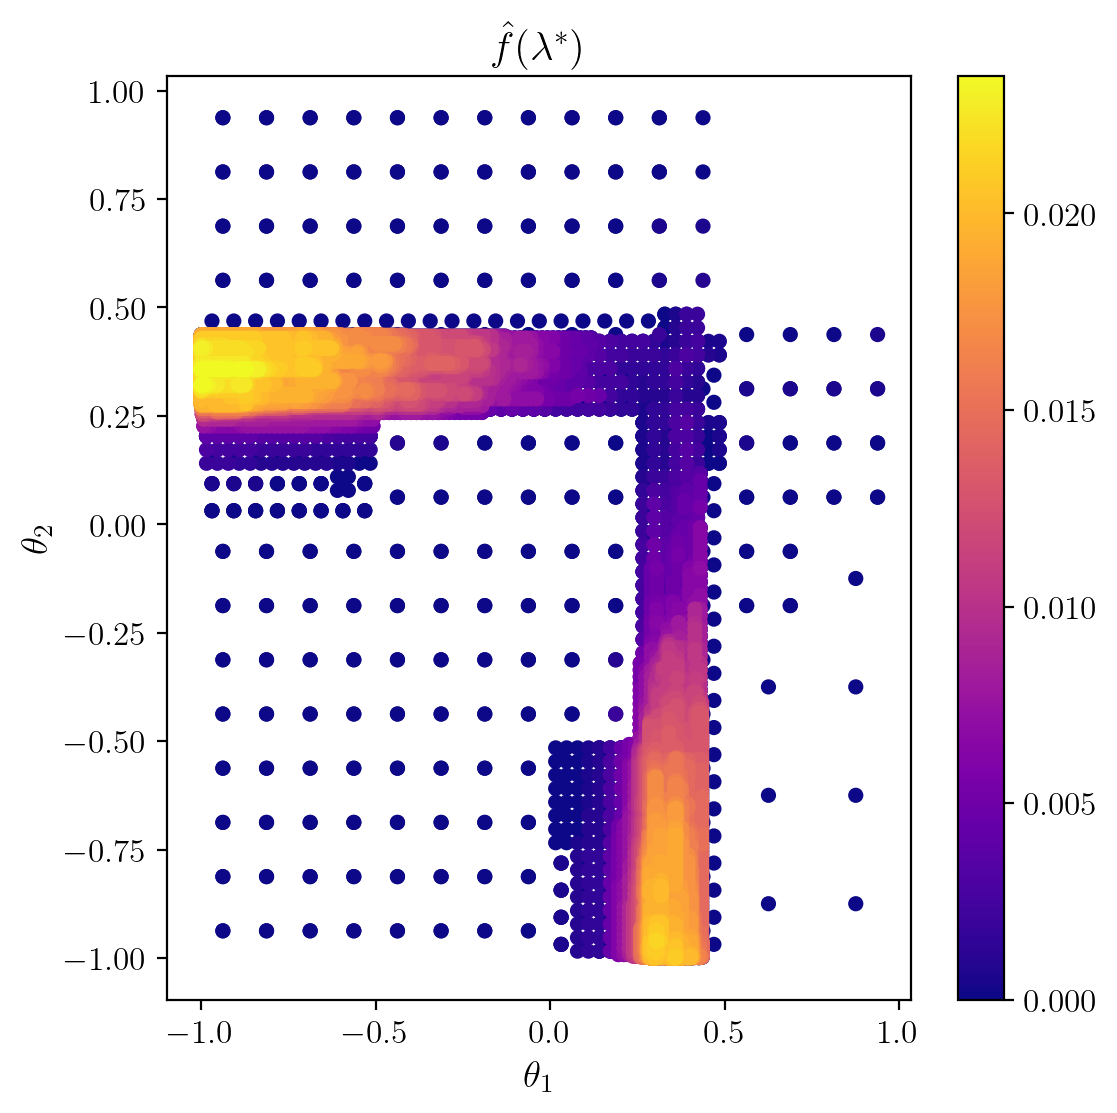

505707


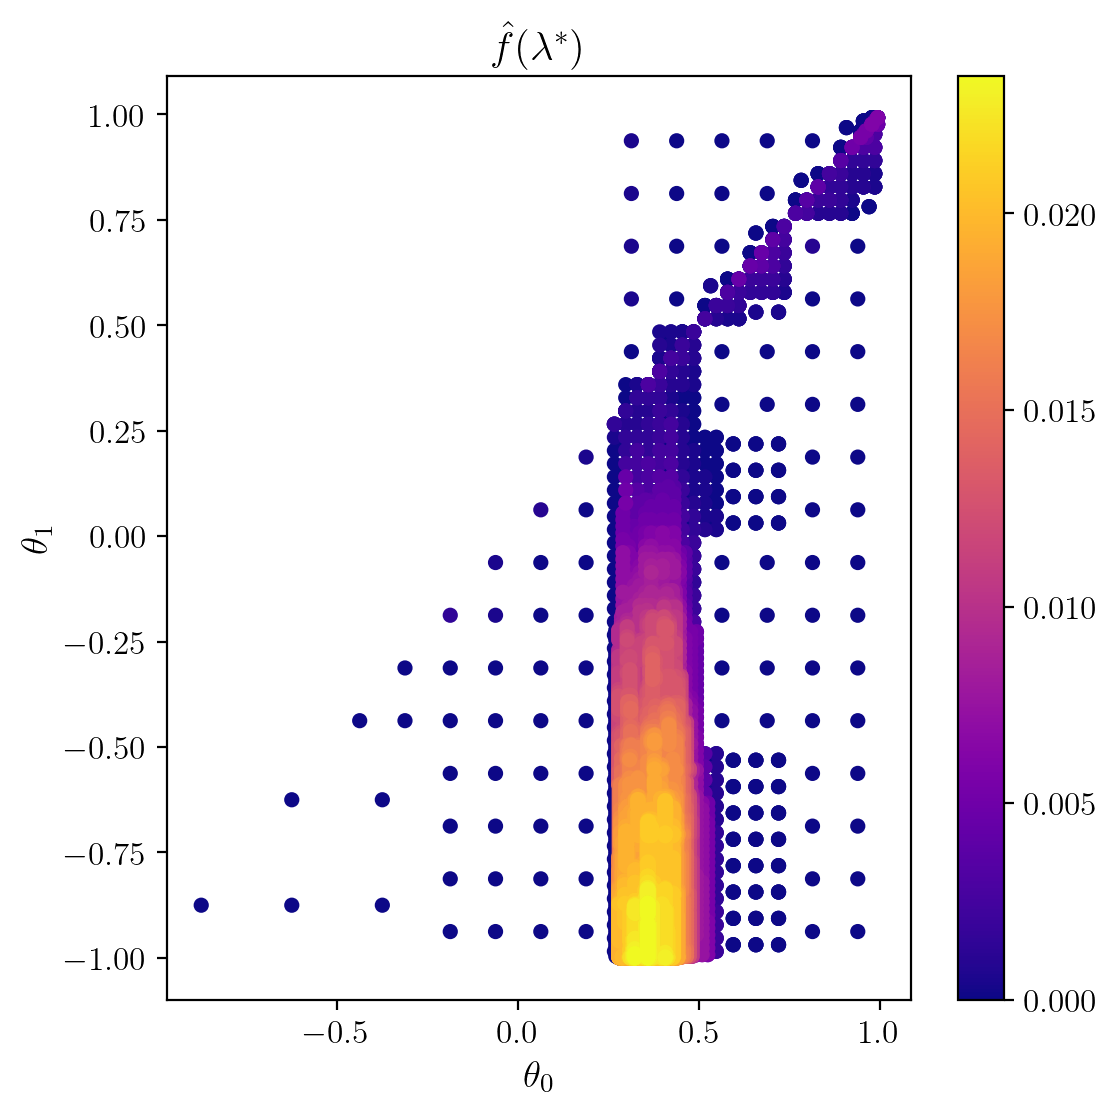

In [45]:
def pandemonium(field):
    for unplot in [0, 2]:
        plot = list({0, 1, 2} - {unplot})
        select = np.where(np.abs(g.theta_tiles[:, unplot] - worst_tile[unplot]) < 0.08)[0]

        ordered_select = select[np.argsort(field[select])]
        print(ordered_select.shape[0])

        plt.figure(figsize=(6, 6))
        plt.title(r"$\hat{f}(\lambda^{*})$")
        plt.scatter(
            g.theta_tiles[ordered_select, plot[0]],
            g.theta_tiles[ordered_select, plot[1]],
            c=field[ordered_select],
            s=20,
        )
        plt.colorbar()
        plt.xlabel(f"$\\theta_{plot[0]}$")
        plt.ylabel(f"$\\theta_{plot[1]}$")
        plt.show()
pandemonium(typeI_est)

614863


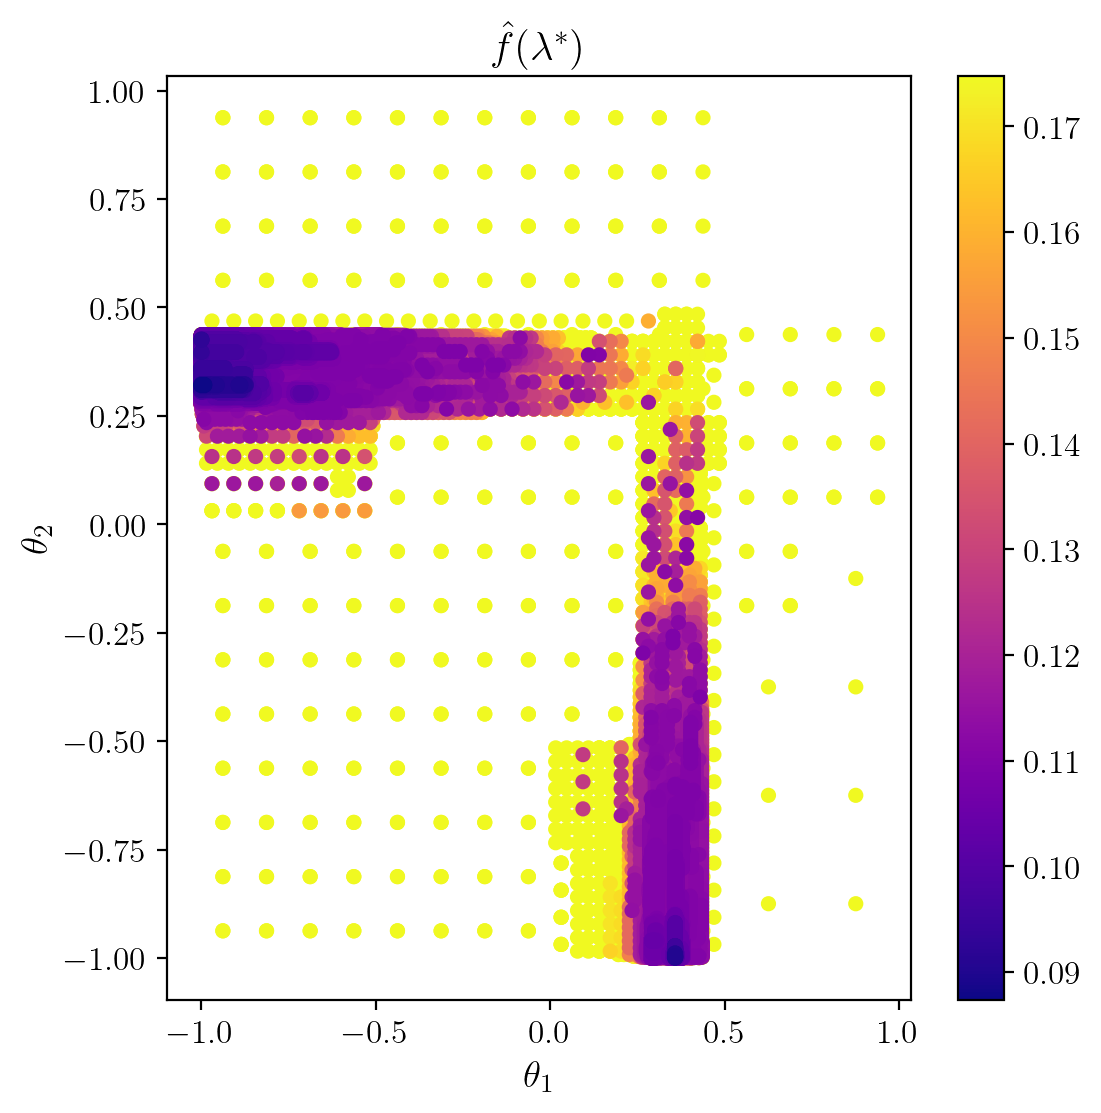

505707


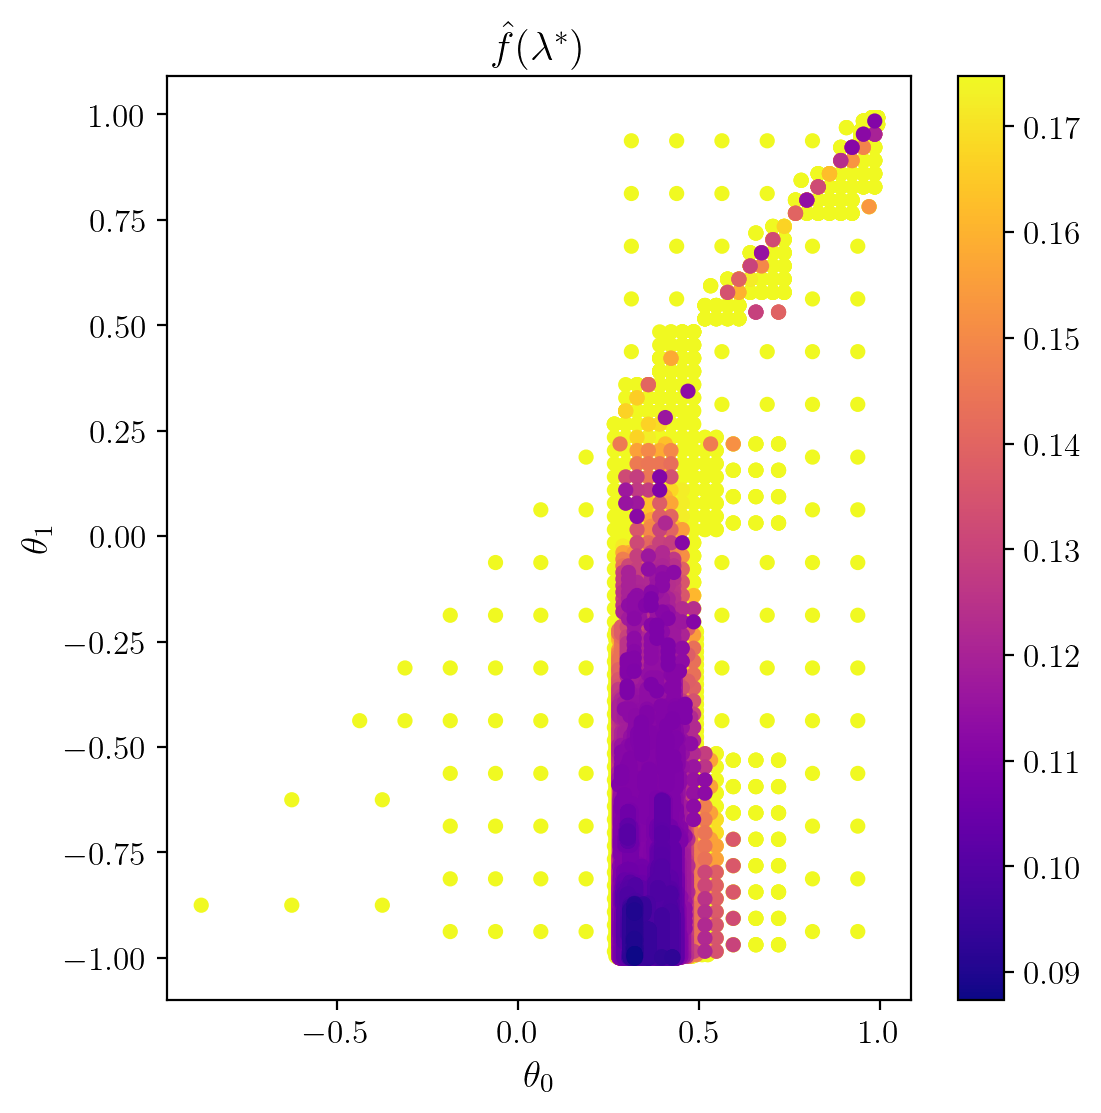

In [48]:
for unplot in [0, 2]:
    plot = list({0, 1, 2} - {unplot})
    select = np.where(np.abs(g.theta_tiles[:, unplot] - worst_tile[unplot]) < 0.08)[0]

    ordered_select = select[np.argsort(sim_cvs[select])[::-1]]
    print(ordered_select.shape[0])

    plt.figure(figsize=(6, 6))
    plt.title(r"$\hat{f}(\lambda^{*})$")
    plt.scatter(
        g.theta_tiles[ordered_select, plot[0]],
        g.theta_tiles[ordered_select, plot[1]],
        c=sim_cvs[ordered_select],
        vmin=overall_cv,
        vmax=overall_cv * 2,
        s=20,
    )
    plt.colorbar()
    plt.xlabel(f"$\\theta_{plot[0]}$")
    plt.ylabel(f"$\\theta_{plot[1]}$")
    plt.show()

In [53]:
(2.0 / g.radii.min()) ** 3 / g.n_tiles

31442.172059354416

In [ ]:
# with open(f'checkpoint/6.pkl', 'rb') as f:
#     g, sim_sizes, sim_cvs, typeI_sum, hob_upper, pointwise_target_alpha = pickle.load(f)

# typeI_est, typeI_CI = binomial.zero_order_bound(
#     typeI_sum, sim_sizes, delta_validate, 1.0
# )
# typeI_bound = typeI_est + typeI_CI
# hob_upper = binomial.holder_odi_bound(
#     typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
# )

    
# sim_cost = typeI_CI
# hob_theory_cost = target_alpha - pointwise_target_alpha
# hob_empirical_cost = hob_upper - typeI_bound

# worst_tile = np.argmin(sim_cvs)
# which_refine = (
#     hob_theory_cost > max(adafrac * hob_theory_cost[worst_tile], target_grid_cost)
# ) & (
#     (hob_upper > adafrac * hob_upper[worst_tile]) | (sim_cvs == sim_cvs[worst_tile])
# )
# which_more_sims = (
#     typeI_CI > max(adafrac * typeI_CI[worst_tile], target_sim_cost)
# ) & (
#     (typeI_bound > adafrac * hob_upper[worst_tile])
#     | (sim_cvs == sim_cvs[worst_tile])
# )

NameError: name 'adafrac' is not defined